### Chest X-Ray Images (Pneumonia) Detection Using Convolutional Neural Networks with pytorch


**Introduction:**

Image Classification is an approach that is being widely utilised for different purposes in the realm of medical imaging and diagnostics. Pneumonia, a potentially life-threatening respiratory infection, poses a significant global health challenge, and rapid and accurate diagnosis is paramount for effective treatment. In an era where healthcare technology is advancing at an unprecedented pace, the importance of this method can't be overstated.Convolutional Neural Networks (CNNs) have emerged as a powerful image classification tool in image analysis, which can also be utilised to detect Pneumonia in Chest X-Ray Images which provides the capabilities to healthcare professionals in identifying pneumonia in diverse clinical scenarios, from crowded emergency rooms to remote telemedicine consultations in real-time.



**Dataset:**

- The dataset is divided into three folders - 'train', 'test', and 'val', and it contains subfolders for different image categories, specifically 'Pneumonia' and 'Normal'. There are a total of 5,863 X-Ray images in JPEG format, falling into these two categories.

- These chest X-ray images were obtained from pediatric patients aged one to five years old. These images were collected at the Guangzhou Women and Children’s Medical Center in Guangzhou, China, as part of their routine clinical care.

- To ensure the quality of the chest X-ray images, they were initially screened to remove any low-quality or unreadable scans. After this, two expert physicians examined and graded the diagnoses before using them to train the AI system. To further ensure accuracy, a third expert checked the evaluation set to account for any grading errors in the diagnoses.

Link to the data card on Kaggle: [Chest X-Ray Images (Pneumonia)](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/data)

Installing and Importing Dependencies

In [1]:
# !pip install kaggle torch torchvision

Downloading Data using Kaggle API directly to colab environment.

In [2]:
# # Mount Google Drive to the Colab Notebook (if using Colab)
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# import os
# from google.colab import files
# files.upload()  # Upload your Kaggle API key (kaggle.json) here.
# !mv kaggle.json /content/drive/MyDrive/kaggle
# os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/kaggle'
# !kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
# !unzip -q -o chest-xray-pneumonia.zip

In [4]:
import sys
print(sys.version)

3.10.9 (main, Mar  1 2023, 12:20:14) [Clang 14.0.6 ]


Importing Modules

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, ConcatDataset, random_split, SubsetRandomSampler
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd

from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

import os
import json
import gc
import pathlib


/Users/ganeshghimire/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
def calculate_transforms(data_dir):
    # Modify this line to ensure the dataset's transform converts images to tensors
    train_dataset = datasets.ImageFolder(data_dir+"train/", transform=transforms.ToTensor())
    first_train_image, _ = train_dataset[0]

    # Make sure first_train_image is a tensor before calling unsqueeze
    if isinstance(first_train_image, Image.Image):
        first_train_image = transforms.ToTensor()(first_train_image)

    first_train_image = first_train_image.unsqueeze(0)  # Add batch dimension
    grid_image = make_grid(first_train_image, normalize=True)  # Create a grid to get a single image

    # Compute mean and std for the first test image
    mean = grid_image.mean(dim=[1,2])
    std = grid_image.std(dim=[1,2])

    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomRotation(15),
            transforms.RandomResizedCrop(56),
            transforms.RandomHorizontalFlip(),
            transforms.RandomAffine(0, translate=(0.1, 0.1)),
            transforms.ToTensor(),
            transforms.Normalize(mean.tolist(), std.tolist())
        ]),
        'val': transforms.Compose([
            transforms.Resize(size=(56, 56)),
            transforms.ToTensor(),
            transforms.Normalize(mean.tolist(), std.tolist())
        ]),
    }

    # Save the transform parameters to a json file for future use
    transform_parameters = {"mean": mean.tolist(), "std": std.tolist()}
    with open('transform_parameters.json', 'w') as f:
        json.dump(transform_parameters, f)

    return data_transforms


def get_data_loaders(data_dir: str, data_transforms: dict, batch_size: int = 64):
    # Loading the datasets with transformations
    train_dataset = datasets.ImageFolder(data_dir+"train/", transform=data_transforms['train'])
    test_dataset = datasets.ImageFolder(data_dir+"test/", transform=data_transforms['val'])
    val_dataset = datasets.ImageFolder(data_dir+"val/", transform=data_transforms['val'])

    # Data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

    return train_dataset, test_dataset, val_dataset, train_loader, test_loader, val_loader

In [7]:
data_dir = "chest_xray/"
data_transforms = calculate_transforms(data_dir)
train_dataset, test_dataset, val_dataset, train_loader, test_loader, val_loader = get_data_loaders(data_dir, data_transforms)

In [8]:
from torch.utils.data import DataLoader, ConcatDataset, random_split

# Identify the minority class
class_counts = {}
for _, label in train_dataset:
    if label in class_counts:
        class_counts[label] += 1
    else:
        class_counts[label] = 1

# Find the class that has the maximum count
max_count = max(class_counts.values())

# Oversample the minority class
datasets_list = [train_dataset]
for label, count in class_counts.items():
    if count < max_count:
        diff = max_count - count
        # Filter out the samples belonging to current class
        minority_samples = [sample for sample in train_dataset if sample[1] == label]
        # Repeat the samples until we reach the desired count
        oversampled_data = minority_samples * (diff // count) + minority_samples[:diff % count]
        datasets_list.append(oversampled_data)

# Concatenate the original dataset with the oversampled data
balanced_dataset = ConcatDataset(datasets_list)

# Shuffle the dataset
train_size = len(balanced_dataset)
train_indices = list(range(train_size))
np.random.shuffle(train_indices)

# Create a DataLoader using the shuffled indices
train_loader = DataLoader(balanced_dataset, batch_size=64, sampler=torch.utils.data.SubsetRandomSampler(train_indices))


In [9]:
def get_model(device):
    """
    Function to get the model.
    """
    class CNN(nn.Module):
        def __init__(self):
            super(CNN, self).__init__()
            self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
            self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
            self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
            self.pool = nn.MaxPool2d(2, 2)
            self.fc1 = nn.Linear(64 * 7 * 7, 512)
            self.fc2 = nn.Linear(512, 2)
            self.dropout = nn.Dropout(0.5)

        def forward(self, x):
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            x = self.pool(F.relu(self.conv3(x)))
            x = x.view(-1, 64 * 7 * 7)
            x = F.relu(self.fc1(x))
            x = self.dropout(x)
            x = self.fc2(x)
            return x

    model = CNN().to(device)
    return model

In [10]:

def train_model(model, train_loader, val_loader, device, num_epochs=10, learning_rate=0.001):
    """
    Function to train the model.
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_val_loss = float("inf")
    train_loss_history, val_loss_history = [], []
    train_accuracy_history, val_accuracy_history = [], []

    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracy = 100 * correct / total
        train_loss = running_loss / len(train_loader)
        train_loss_history.append(train_loss)
        train_accuracy_history.append(train_accuracy)

        # Validation
        model.eval()
        running_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_accuracy = 100 * correct / total
        val_loss = running_loss / len(val_loader)
        val_loss_history.append(val_loss)
        val_accuracy_history.append(val_accuracy)

        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

        # Create a directory if not exists
        saved_models_dir = 'saved_models'
        if not os.path.exists(saved_models_dir):
            os.makedirs(saved_models_dir)

        # Save the model if it has the best validation loss so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_path = os.path.join(saved_models_dir, 'best_model.pth')
            torch.save(model.state_dict(), best_model_path)
            print('Model checkpoint saved at {}'.format(best_model_path))

    return model, train_loss_history, train_accuracy_history, val_loss_history, val_accuracy_history


In [11]:
def evaluate_model(model, test_loader, device, class_names):
    """
    Function to evaluate the model.
    """
    model.eval()
    correct, total = 0, 0
    true_labels, pred_labels = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total

    # Classification report
    print('Classification Report:')
    print(classification_report(true_labels, pred_labels, target_names=class_names))

    # Confusion matrix
    conf_matrix = confusion_matrix(true_labels, pred_labels)
    df_cm = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)
    plt.figure(figsize=(5,5))
    sns.heatmap(df_cm, annot=True, fmt="d", cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig("confusion_matrix.png")
    plt.show()

    return accuracy, true_labels, pred_labels

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_dir = "chest_xray/chest_xray/"
num_epochs = 12
batch_size = 64

In [13]:
class_names = train_dataset.classes

In [14]:
model = get_model(device)

In [15]:
model, train_loss, train_acc, val_loss, val_acc = train_model(model, train_loader, val_loader, device, num_epochs)

Epoch 1/12, Train Loss: 0.5203, Train Acc: 74.40%, Val Loss: 0.5446, Val Acc: 68.75%
Model checkpoint saved at saved_models/best_model.pth
Epoch 2/12, Train Loss: 0.4176, Train Acc: 82.61%, Val Loss: 0.4790, Val Acc: 75.00%
Model checkpoint saved at saved_models/best_model.pth
Epoch 3/12, Train Loss: 0.3680, Train Acc: 84.58%, Val Loss: 0.4571, Val Acc: 68.75%
Model checkpoint saved at saved_models/best_model.pth
Epoch 4/12, Train Loss: 0.3520, Train Acc: 85.54%, Val Loss: 0.5595, Val Acc: 68.75%
Epoch 5/12, Train Loss: 0.3301, Train Acc: 86.58%, Val Loss: 0.4430, Val Acc: 75.00%
Model checkpoint saved at saved_models/best_model.pth
Epoch 6/12, Train Loss: 0.3092, Train Acc: 86.94%, Val Loss: 0.8718, Val Acc: 62.50%
Epoch 7/12, Train Loss: 0.3054, Train Acc: 87.65%, Val Loss: 0.9867, Val Acc: 62.50%
Epoch 8/12, Train Loss: 0.2802, Train Acc: 89.12%, Val Loss: 0.5869, Val Acc: 75.00%
Epoch 9/12, Train Loss: 0.2677, Train Acc: 89.41%, Val Loss: 0.5936, Val Acc: 68.75%
Epoch 10/12, Train 

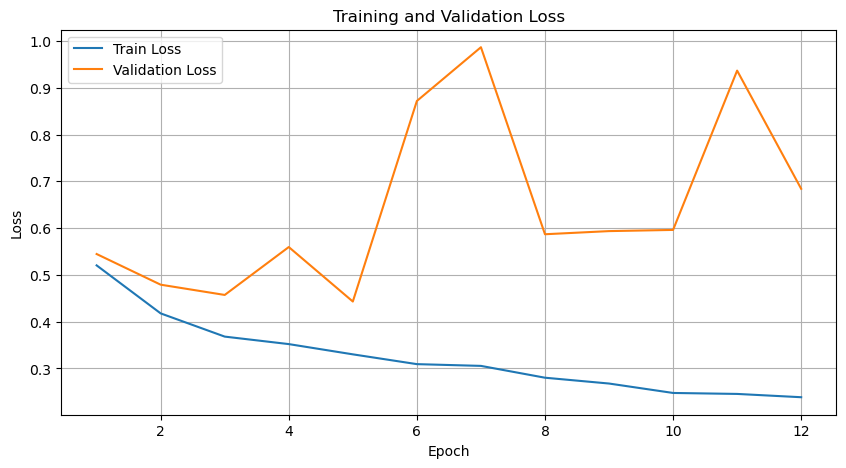

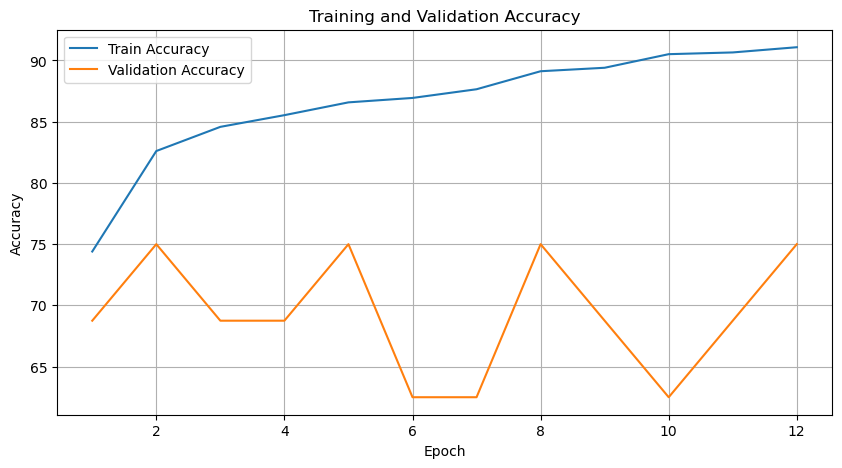

In [16]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_loss, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.savefig("validation_train loss.png")
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_acc, label="Train Accuracy")
plt.plot(range(1, num_epochs + 1), val_acc, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.grid(True)
plt.savefig("validation_train accuracy.png")
plt.show()

In [18]:
checkpoint_path = 'saved_models/best_model.pth'
# Load the best model checkpoint
best_model = get_model(device)
best_model.load_state_dict(torch.load(checkpoint_path))

<All keys matched successfully>

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.65      0.88      0.75       234
   PNEUMONIA       0.91      0.71      0.80       390

    accuracy                           0.78       624
   macro avg       0.78      0.80      0.77       624
weighted avg       0.81      0.78      0.78       624



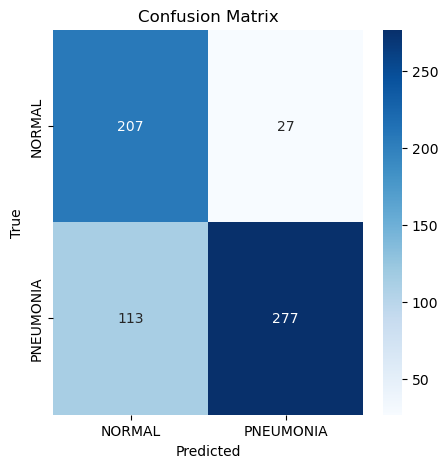

Test Accuracy: 77.56410256410257%


In [19]:
accuracy, true_labels, pred_labels = evaluate_model(best_model, test_loader, device, class_names)
print(f'Test Accuracy: {accuracy}%')